In [21]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# PARAMETERS
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_INITIAL = 10
NUM_EPOCHS_FINETUNE = 5
DATA_PATH = "Aeroplane-Ai/DataSet"

# STEP 1: DATA PREPARATION & AUGMENTATION
# ---------------------------------------
# We'll split the data into training and validation sets using ImageDataGenerator's built-in splitting.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

num_classes = len(train_generator.class_indices)
print("Number of Classes:", num_classes)

Found 1752 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Number of Classes: 3


In [23]:
# STEP 2: LOAD THE PRETRAINED MODEL & BUILD A CUSTOM HEAD
# ---------------------------------------------------------
# The base model (EfficientNetB3) processes images and extracts meaningful features like edges, textures, and object shapes.
# EfficientNetB3 is already optimized, so it saves time and boosts accuracy.
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# The custom head takes those features and classifies them into specific airplane models.
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensionality while keeping essential features.
x = Dense(256, activation='relu')(x) # Adds a fully connected layer to learn from extracted features.
x = Dropout(0.5)(x) # Prevents overfitting by randomly disabling 50% of neurons during training.
predictions = Dense(num_classes, activation='softmax')(x) # Final classification layer for aircraft types.

# Combine the base model and the new head into a final model
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
# STEP 3: COMPILE THE MODEL
# ---------------------------
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,177,778 (42.64 MB)

 Trainable params: 11,090,475 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [25]:
# STEP 4: INITIAL TRAINING
# --------------------------
# Train only the custom head; the base model remains frozen.

# CALLBACKS: Learning Rate Reduction & Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_INITIAL,
    validation_data=validation_generator
)

C:\Users\dawny\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.4884 - loss: 0.9917 - val_accuracy: 0.0915 - val_loss: 1.2351
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.5897 - loss: 0.7647 - val_accuracy: 0.5057 - val_loss: 1.0613
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.7327 - loss: 0.5287 - val_accuracy: 0.5149 - val_loss: 0.9489
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8230 - loss: 0.4144 - val_accuracy: 0.5469 - val_loss: 0.9680
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8439 - loss: 0.3385 - val_accuracy: 0.5332 - val_loss: 1.0101
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9050 - loss: 0.2686 - val_accuracy: 0.5103 - val_loss: 1.1523
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9250 - loss: 0.1915 - val_accuracy: 0.5309 - val_loss: 1.4107
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.9324 - loss: 0.1839 - val_accuracy: 0.5492 - v

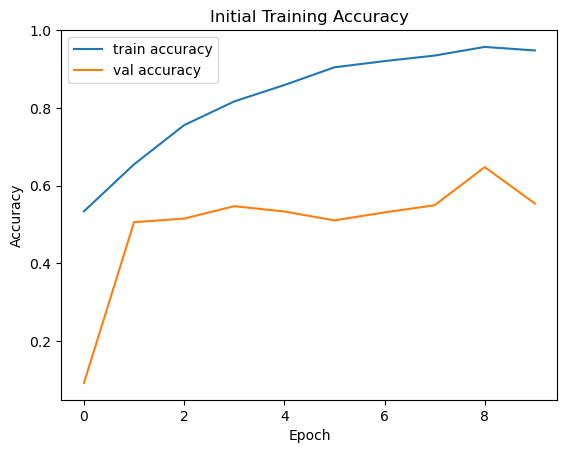

In [26]:
# Plot training history 
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Learning is happening, but the gap between train and validation accuracy suggests overfitting in later epochs.

In [27]:
# STEP 5: FINE-TUNING THE MODEL 
# ------------------------------------------
# Unfreeze the top few layers of the base model for fine-tuning.
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_FINETUNE,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9571 - loss: 0.1083 - val_accuracy: 0.6201 - val_loss: 1.4806 - learning_rate: 1.0000e-05
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9681 - loss: 0.0867 - val_accuracy: 0.6957 - val_loss: 1.3346 - learning_rate: 1.0000e-05
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9669 - loss: 0.1057 - val_accuracy: 0.7368 - val_loss: 1.0274 - learning_rate: 1.0000e-05
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9647 - loss: 0.0979 - val_accuracy: 0.6842 - val_loss: 1.3365 - learning_rate: 1.0000e-05
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9638 - loss: 0.1023 - val_accuracy: 0.7048 - val_loss: 1.0774 - learning_rate: 1.0000e-05


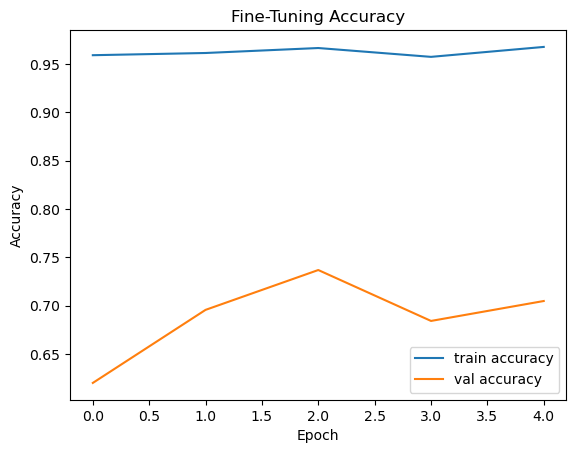

In [28]:
# Plot fine-tuning history 
plt.plot(history_finetune.history['accuracy'], label='train accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Overfitting might be occurring - the model learns well on the training data but struggles to generalize to new data.

In [30]:
# STEP 6: EVALUATE THE MODEL ON A TEST SET
# ------------------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_PATH,  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 2189 images belonging to 3 classes.
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 619ms/step - accuracy: 0.9566 - loss: 0.1663
Test Accuracy: 0.8881


In [148]:
# Get raw probability outputs from the test generator
predictions = model.predict(test_generator)

# Convert probabilities to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class indices from the generator
true_class_indices = test_generator.classes

# Print class labels for better understanding
class_labels = list(test_generator.class_indices.keys())
print("\nClass Labels:")
for i, label in enumerate(class_labels):
    print(f"{i}: {label}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 573ms/step

Class Labels:
0: ATR
1: Airbus
2: Boeing


In [149]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

def predict_from_directory(directory_path):
    class_labels = {0: 'ATR', 1: 'Airbus', 2: 'Boeing'} 
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):  # Check for image files
            img_path = os.path.join(directory_path, filename)
            img_array = preprocess_image(img_path)
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)  # Get the class index
            
            predicted_label = class_labels.get(predicted_class[0], "Unknown")
            print(f"Image: {filename} → Predicted Class: {predicted_label}")

directory_path = 'Aeroplane-Ai/test_images/' 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Image: 737max.jpg → Predicted Class: Airbus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Image: 777-1.jpg → Predicted Class: Boeing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Image: a330-1.jpg → Predicted Class: Airbus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Image: a3501.jpg → Predicted Class: Airbus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Image: a380-1.jpg → Predicted Class: Airbus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Image: atr72-1.jpg → Predicted Class: ATR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Image: indigo_airbus.jpg → Predicted Class: Airbus
